In [65]:
from sklearn.datasets import load_iris

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from seaborn import set_style
set_style("whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [66]:
# Load the data.
date = pd.read_csv("../Data/dim_date.csv")
claims = pd.read_csv("../Data/dim_claims.csv")
pa = pd.read_csv("../Data/dim_pa.csv")
bridge = pd.read_csv("../Data/bridge.csv")

In [67]:
# Join claims with bridge, in df dataframe.
df = claims.copy()
df = df.set_index('dim_claim_id').join(bridge.set_index('dim_claim_id'))
df.head()

# Join the pa with rejected claims, in pa_df dataframe.
pa_df = df.copy().dropna()
pa_df = pa_df.set_index('dim_pa_id').join(pa.set_index('dim_pa_id'))
pa_df.head()

,bin,drug,reject_code,pharmacy_claim_approved,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
dim_pa_id,,,,,,,,,
1.0,417380,A,75.0,0,1,1,1,0,1
2.0,417740,A,76.0,0,1,1,0,0,1
3.0,417380,A,75.0,0,1,0,0,1,1
4.0,999001,A,76.0,0,1,1,1,0,1
5.0,417614,A,70.0,0,1,0,1,0,1


In [68]:
## Map bins
## 417380 -> 0
## 417614 -> 1
## 417740 -> 2
## 999001 -> 3

pa_df['bin_no'] = 3
pa_df.loc[pa_df.bin == 417380,'bin_no'] = 0
pa_df.loc[pa_df.bin == 417614,'bin_no'] = 1
pa_df.loc[pa_df.bin == 417740,'bin_no'] = 2

## Map drugs
## A -> 0
## B -> 1
## C -> 2

pa_df['drug_no'] = 0
pa_df.loc[pa_df.drug == 'B','drug_no'] = 1
pa_df.loc[pa_df.drug == 'C','drug_no'] = 2

## Map reject codes
## 70.0 -> 0
## 75.0 -> 1
## 76.0 -> 2

pa_df['reject_no'] = 0
pa_df.loc[pa_df.reject_code == 75.0,'reject_no'] = 1
pa_df.loc[pa_df.reject_code == 76.0,'reject_no'] = 2

In [69]:
concat_features = ['bin_no', 'drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication']

pa_df['feature_code'] = ''

for feature in concat_features:
    pa_df['feature_code'] = pa_df['feature_code'] + pa_df[feature].astype(str)
    
pa_df['concat_all'] = pa_df['feature_code'] + pa_df['pa_approved'].astype(str)


In [70]:
random_state = 2;

# Perform train-test split.
pa_train, pa_test = train_test_split( pa_df.copy(),
                                      test_size = .2,
                                      random_state = random_state,
                                      shuffle = True,
                                      stratify = pa_df['concat_all'])

In [71]:
pa_val_counts = pd.DataFrame(pa_train['concat_all'].value_counts(sort = False))
pa_val_counts = pa_val_counts.reset_index()
pa_val_counts.columns = ['unique_values', 'counts']

pa_val_counts['pa_approved'] = pa_val_counts['unique_values'].str.strip().str[-1]
pa_val_counts['feature_code'] = pa_val_counts['unique_values'].str.strip().str[:-1]
pa_val_counts = pa_val_counts.sort_values('unique_values')
pa_val_counts = pa_val_counts.reset_index().drop(columns = 'index')

In [72]:
# This can be used as the contingency table, but zero-values are not present.
pa_val_counts

,unique_values,counts,pa_approved,feature_code
0,0010000,30,0,001000
1,0010001,5721,1,001000
2,0010010,110,0,001001
3,0010011,1358,1,001001
4,0010100,6,0,001010
...,...,...,...,...
187,3221011,357,1,322101
188,3221100,410,0,322110
189,3221101,3604,1,322110
190,3221110,407,0,322111


In [24]:
# Form an array containing all possible unique_values from the above df.

all_features = []

for bn in range(4): #bin no
    for dn in range(3): #drug no
        for rn in range(3): # rejection no.
            for cd in range(2): # correct diagnosis
                for tf in range(2): # tried & failed
                    for ci in range(2): # contraindication
                        for pa in range(2): #pa_approved
                            all_features.append(str(bn)+str(dn)+str(rn)+str(cd)+str(tf)+str(ci)+str(pa))
    

In [25]:
cont_table = pa_val_counts.copy()

In [26]:
# Add the zero values to the contingency table.

for feature in all_features:
    if(not(feature in cont_table['unique_values'].unique())):
        df = pd.DataFrame({'unique_values': [feature], 'counts': [0], 'pa_approved': [feature[-1]], 'feature_id': [feature[:-1]] })
        cont_table = pd.concat([cont_table, df], ignore_index=True)

# Sort values and reset index.
cont_table = cont_table.sort_values('unique_values')
cont_table = cont_table.reset_index()
cont_table = cont_table.drop(columns = ['index'])

In [27]:
# Create the 7-dimensional contingency array

cont_array = np.zeros((4,3,3,2,2,2,2))

for bn in range(4): #bin no
    for dn in range(3): #drug no
        for rn in range(3): # rejection no.
            for cd in range(2): # correct diagnosis
                for tf in range(2): # tried & failed
                    for ci in range(2): # contraindication
                        for pa in range(2): #pa_approved
                            unique_value = str(bn)+str(dn)+str(rn)+str(cd)+str(tf)+str(ci)+str(pa)
                            cont_array[bn,dn,rn,cd,tf,ci,pa] = cont_table.loc[cont_table['unique_values'] == unique_value]['counts'].values[0]

In [28]:
# Calculate the approval rates.
# If the cells corresponding to the feature string are 0, calculate the new contingency tables without
# 1) "correct_diagnosis"
# 2) "bin_no"
# 3) "correct_diagnosis" & "bin_no"
# in this order.
# Note these are the two least important features according to both CatBoost and XGBoost models,
# and removing them lets us construct a contingency table without 0-cells.

values = []
approval_rates = []

for bn in range(4):
    for dn in range(3):
        for rn in range(3):
            for cd in range(2):
                for tf in range(2):
                    for ci in range(2):
                        values.append(str(bn)+str(dn)+str(rn)+str(cd)+str(tf)+str(ci))
                        if (not(cont_array[bn,dn,rn,cd,tf,ci,0] == 0 and cont_array[bn,dn,rn,cd,tf,ci,1] == 0)):
                            app_rate = cont_array[bn,dn,rn,cd,tf,ci,1]/np.sum(cont_array[bn,dn,rn,cd,tf,ci,:])
                        else:
                            a = np.sum(cont_array,axis = 3)
                            if (not(a[bn,dn,rn,tf,ci,0] == 0 and a[bn,dn,rn,tf,ci,1] == 0)):
                                app_rate = a[bn,dn,cd,tf,ci,1]/np.sum(a[bn,dn,cd,tf,ci,:])
                            else:
                                a = np.sum(cont_array,axis = 0)
                                if (not(a[dn,rn,cd,tf,ci,0] == 0 and a[dn,rn,cd,tf,ci,1] == 0)):
                                    app_rate = a[dn,rn,cd,tf,ci,1]/np.sum(a[dn,rn,cd,tf,ci,:])
                                else:
                                    a = np.sum(cont_array,axis = (0,3))
                                    if (not(a[dn,rn,tf,ci,0] == 0 and a[dn,rn,tf,ci,1] == 0)):
                                        app_rate = a[dn,rn,cd,tf,ci,1]/np.sum(a[dn,rn,cd,tf,ci,:])
                                    else:
                                        print("not found")
                        approval_rates.append(app_rate*100)

In [29]:
df1 = pd.DataFrame (values, columns = ['Feature Codes'])
df2 = pd.DataFrame (approval_rates, columns = ['PA Approval Rates(%)'])
LT_df = pd.concat([df1,df2],axis=1)
LT_df

,Feature Codes,PA Approval Rates(%)
0,000000,50.416207
1,000001,14.113060
2,000010,71.127113
3,000011,31.339713
4,000100,57.939270
...,...,...
283,322011,47.863248
284,322100,77.763396
285,322101,38.181818
286,322110,89.785750


In [30]:
# Set the threshold percentage.

thresholds = range(20,82,2)
metrics = np.zeros((len(thresholds), 5))
i = 0
for threshold in thresholds:
    y = 'Predictions(T=' + str(threshold) + ')'
    Model = LT_df.copy()
    Model[y] = (LT_df['PA Approval Rates(%)'] > threshold) + 0
    y_preds = [Model.loc[Model['Feature Codes'] == x][y].values[0] for x in pa_test['feature_id']]
    metrics[i,0] = accuracy_score(pa_test['pa_approved'], y_preds)
    metrics[i,1] = precision_score(pa_test['pa_approved'], y_preds)
    metrics[i,2] = recall_score(pa_test['pa_approved'], y_preds)
    metrics[i,3] = f1_score(pa_test['pa_approved'], y_preds)
    metrics[i,4] = roc_auc_score(pa_test['pa_approved'], y_preds)
    i = i+1
    # print(i)
    

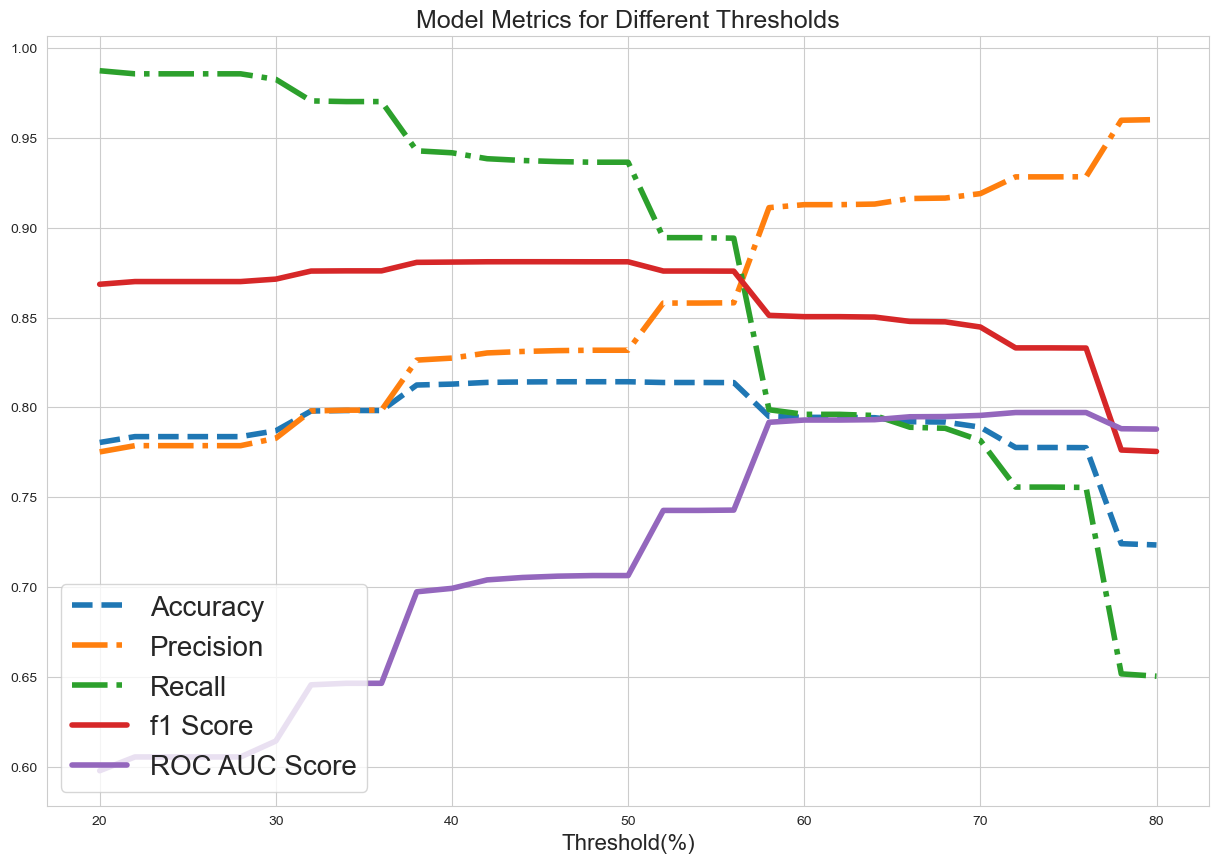

In [31]:
# Accuracy plot
plt.figure(figsize = (15,10))

plt.plot(thresholds,
            metrics[:,0],
            '--',linewidth=4, label = "Accuracy")

# Precision plot.
plt.plot(thresholds,
            metrics[:,1],
            '-.',linewidth=4, label = "Precision")

# Recall plot.
plt.plot(thresholds,
            metrics[:,2],
            '-.',linewidth=4, label = "Recall")

#f1 Score plot.
plt.plot(thresholds,
            metrics[:,3],
            linewidth=4, label = "f1 Score")

#ROC AUC Score plot.
plt.plot(thresholds,
            metrics[:,4],
            linewidth=4, label = "ROC AUC Score")

plt.legend(fontsize = 20,loc = 3)
plt.xlabel("Threshold(%)",fontsize = 16)
plt.title("Model Metrics for Different Thresholds", fontsize=18)
plt.show()

In [32]:
def weighted_harmonic_mean(value1, value2, weight1, weight2):
    return (weight1 + weight2) / (weight1/value1 + weight2/value2)

In [51]:
best_weighted_f1 = 0.866831


length = len(thresholds)

weighted_f1s = np.zeros(length)
precision_weight = 2
recall_weight = 1

for i in range(length):
    weighted_f1s[i] = weighted_harmonic_mean(metrics[i,1], metrics[i,2], precision_weight, recall_weight)


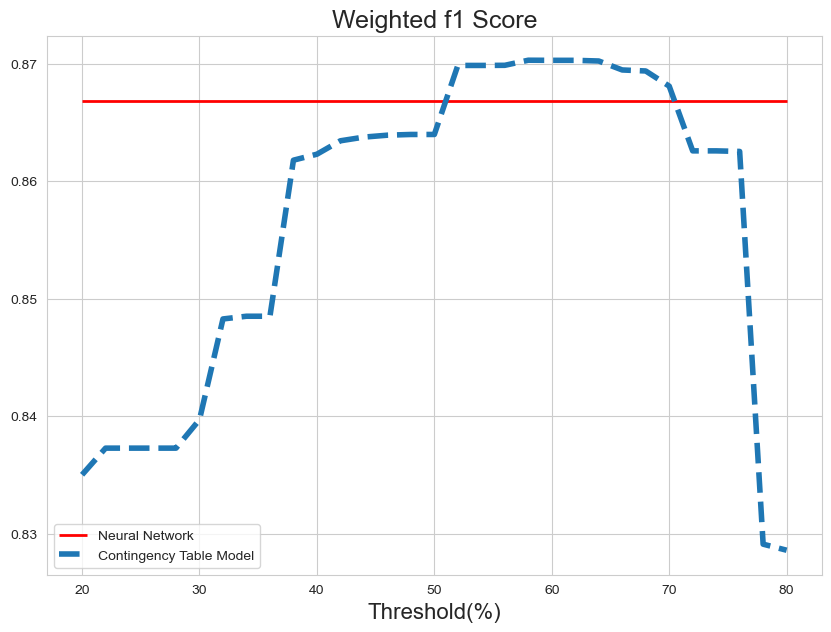

In [64]:
# Accuracy plot
fig, ax = plt.subplots(figsize = (10,7))

ax.hlines(y = best_weighted_f1, xmin = thresholds[0], xmax = thresholds[-1] , linewidth=2, color='r', label = 'Neural Network')

ax.plot(thresholds,weighted_f1s ,'--',linewidth=4 , label = 'Contingency Table Model')


plt.xlabel("Threshold(%)",fontsize = 16)
plt.title("Weighted f1 Score", fontsize=18)
plt.legend(fontsize = 10, loc = 3)
plt.show()

In [60]:
weighted_f1s[20]

0.8702941005858809

In [19]:
# Get the metrics for a specific threshold

threshold = 50

y = 'Predictions(T=' + str(threshold) + ')'
Model = LT_df.copy()
Model[y] = (LT_df['PA Approval Rates(%)'] > threshold) + 0
y_preds = [Model.loc[Model['Feature Codes'] == x][y].values[0] for x in pa_df['feature_id']]
accuracy = accuracy_score(pa_df['pa_approved'], y_preds)
precision = precision_score(pa_df['pa_approved'], y_preds)
recall = recall_score(pa_df['pa_approved'], y_preds)
f1 = f1_score(pa_df['pa_approved'], y_preds)
roc_auc = roc_auc_score(pa_df['pa_approved'], y_preds)

print("Results for " + str(threshold) + "% threshold:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1_score: ", f1)
print("ROC AUC score: ", roc_auc)

Results for 50% threshold:
Accuracy:  0.81423182978356
Precision:  0.8317689719154527
Recall:  0.9364736884641665
f1_score:  0.881021337775535
ROC AUC score:  0.7063051492066145


In [ ]:
## This shows that if we remove bin_no and correct_diagnosis, we get a contingency table without 0-cells. 
# So the above code always works.

# Load the data.
date = pd.read_csv("../Data/dim_date.csv")
claims = pd.read_csv("../Data/dim_claims.csv")
pa = pd.read_csv("../Data/dim_pa.csv")
bridge = pd.read_csv("../Data/bridge.csv")

# Join claims with bridge, in df dataframe.
df = claims.copy()
df = df.set_index('dim_claim_id').join(bridge.set_index('dim_claim_id'))
df.head()
# Join the pa with rejected claims, in pa_df dataframe.
pa_df = df.copy().dropna()
pa_df = pa_df.set_index('dim_pa_id').join(pa.set_index('dim_pa_id'))
pa_df.head()

## Map bins
## 417380 -> 0
## 417614 -> 1
## 417740 -> 2
## 999001 -> 3

pa_df['bin_no'] = 3
pa_df.loc[pa_df.bin == 417380,'bin_no'] = 0
pa_df.loc[pa_df.bin == 417614,'bin_no'] = 1
pa_df.loc[pa_df.bin == 417740,'bin_no'] = 2

## Map drugs
## A -> 0
## B -> 1
## C -> 2

pa_df['drug_no'] = 0
pa_df.loc[pa_df.drug == 'B','drug_no'] = 1
pa_df.loc[pa_df.drug == 'C','drug_no'] = 2

## Map reject codes
## 70.0 -> 0
## 75.0 -> 1
## 76.0 -> 2

pa_df['reject_no'] = 0
pa_df.loc[pa_df.reject_code == 75.0,'reject_no'] = 1
pa_df.loc[pa_df.reject_code == 76.0,'reject_no'] = 2


####Change features here! 
# cd < bn < tf < ci < dn < rn
## concat_features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis','tried_and_failed', 'contraindication']
## concat_features = ['bin_no','drug_no', 'reject_no','tried_and_failed', 'contraindication']
concat_features = ['drug_no', 'reject_no', 'correct_diagnosis','tried_and_failed', 'contraindication']


pa_df['feature_id'] = ''

for feature in concat_features:
    pa_df['feature_id'] = pa_df['feature_id'] + pa_df[feature].astype(str)
    
pa_df['concat_all'] = pa_df['feature_id'] + pa_df['pa_approved'].astype(str)

pa_val_counts = pd.DataFrame(pa_df['concat_all'].value_counts(sort = False))
pa_val_counts = pa_val_counts.reset_index()
pa_val_counts.columns = ['unique_values', 'counts']

pa_val_counts['pa_approved'] = pa_val_counts['unique_values'].str.strip().str[-1]
pa_val_counts['feature_id'] = pa_val_counts['unique_values'].str.strip().str[:-1]
pa_val_counts = pa_val_counts.sort_values('unique_values')
pa_val_counts = pa_val_counts.reset_index().drop(columns = 'index')

pa_val_counts.loc[pa_val_counts['counts'] == 0]

# Form an array containing all possible unique_values from the above df.

all_features = []

## Don't forget to change this loop accordingly
#for bn in range(4): #bin no
for dn in range(3): #drug no
        for rn in range(3): # rejection no.
            for cd in range(2): # correct diagnosis
                for tf in range(2): # tried & failed
                    for ci in range(2): # contraindication
                        for pa in range(2): #pa_approved
                            #all_features.append(str(bn)+str(dn)+str(rn)+str(cd)+str(tf)+str(ci)+str(pa))
                            all_features.append(str(dn)+str(rn)+str(cd)+str(tf)+str(ci)+str(pa))
                        
cont_table = pa_val_counts.copy()

# Add the zero values to the contingency table.

for feature in all_features:
    if(not(feature in cont_table['unique_values'].unique())):
        df = pd.DataFrame({'unique_values': [feature], 'counts': [0], 'pa_approved': [feature[-1]], 'feature_id': [feature[:-1]] })
        cont_table = pd.concat([cont_table, df], ignore_index=True)

# Sort values and reset index.
cont_table = cont_table.sort_values('unique_values')
cont_table = cont_table.reset_index()
cont_table = cont_table.drop(columns = ['index'])

cont_table.loc[cont_table['counts'] == 0]